In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pickle import dump

In [9]:
data_sent = pd.read_csv('data/data_sentiment.csv')

In [10]:
prices_hist = pd.read_csv('data/stock_yfinance_data.csv')

In [11]:
prices_hist

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [12]:
data_sent['Date'] = pd.to_datetime(data_sent['Date'])  # Convert 'Date' column to datetime

data_sent['Day'] = data_sent['Date'].dt.date 

In [13]:
twitter_df = data_sent.groupby('Day').mean()

C:\Users\ondre\AppData\Local\Temp\ipykernel_21368\1653416127.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  twitter_df = data_sent.groupby('Day').mean()


In [14]:
twitter_df['Date'] = twitter_df.index

In [15]:
twitter_df = twitter_df.reset_index(drop=True)

In [16]:
twitter_df

,positive,neutral,negative,Date
0,0.462636,0.384334,0.153029,2021-09-30
1,0.443135,0.416129,0.140733,2021-10-01
2,0.566429,0.353691,0.079874,2021-10-02
3,0.471656,0.382524,0.145822,2021-10-03
4,0.289329,0.466137,0.244536,2021-10-04
...,...,...,...,...
360,0.346893,0.473361,0.179742,2022-09-25
361,0.352976,0.499048,0.147974,2022-09-26
362,0.416758,0.423305,0.159937,2022-09-27
363,0.390465,0.412678,0.196851,2022-09-28


In [17]:
twitter_df['Date'][0]

datetime.date(2021, 9, 30)

In [18]:
prices_hist['Date'][0]

'2021-09-30'

In [19]:
prices_hist['Date'] = pd.to_datetime(prices_hist['Date'])
twitter_df['Date'] = pd.to_datetime(twitter_df['Date'])

In [20]:
df = pd.merge(twitter_df, prices_hist, on='Date', how='inner')

In [91]:
tesla = df[df['Stock Name'] == 'TSLA']

In [22]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [66]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset,y_scaler)

In [67]:
tesla = tesla.sort_values(by='Date')
tesla = tesla.drop(columns='Date')
tesla = tesla.drop(columns='Stock Name')

In [68]:
tsl_train, tsl_test = split_train_test(tesla)

In [69]:
tsl_train_x, tsl_train_y, y_scaler_train =  normalize_data(tsl_train, (-1,1), "Close")
tsl_test_x, tsl_test_y, y_scaler_test =  normalize_data(tsl_test, (-1,1), "Close")

In [70]:
# Define LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(tsl_train_x.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

c:\Users\ondre\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(tsl_train_x, tsl_train_y, epochs=100, batch_size=32)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1729
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0696
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━

In [77]:
predictions = model.predict(tsl_test_x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [82]:
# Inverse scale the predictions
predictions = y_scaler_test.inverse_transform(predictions)

In [85]:
tsl_test_y = y_scaler_test.inverse_transform(tsl_test_y)

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# For regression problems
mse = mean_squared_error(predictions, tsl_test_y)
mae = mean_absolute_error(predictions, tsl_test_y)
rmse = np.sqrt(mse)

In [87]:
rmse

2.4728778797977586

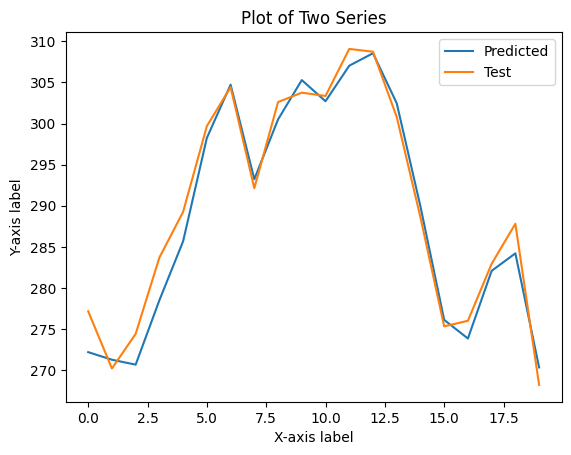

In [89]:
import matplotlib.pyplot as plt

# Assuming series1 and series2 are your two series
# series1 = ...
# series2 = ...

# Plotting the two series
plt.plot(predictions, label='Predicted')
plt.plot(tsl_test_y, label='Test')

# Adding labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Plot of Two Series')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()